# Variable Inspector Widget

## A short example implementation

This notebook demonstrates how one can use the widgets already built in to IPython to create a working variable inspector much like the ones seen in popular commercial scientific computing environments.

In [1]:
import ipywidgets as widgets # Loads the Widget framework.
from IPython.core.magics.namespace import NamespaceMagics # Used to query namespace.

# For this example, hide these names, just to avoid polluting the namespace further
get_ipython().user_ns_hidden['widgets'] = widgets
get_ipython().user_ns_hidden['NamespaceMagics'] = NamespaceMagics

In [2]:
class VariableInspectorWindow(object):
    instance = None
    
    def __init__(self, ipython):
        """Public constructor."""
        if VariableInspectorWindow.instance is not None:
            raise Exception("""Only one instance of the Variable Inspector can exist at a 
                time.  Call close() on the active instance before creating a new instance.
                If you have lost the handle to the active instance, you can re-obtain it
                via `VariableInspectorWindow.instance`.""")
        
        VariableInspectorWindow.instance = self
        self.closed = False
        self.namespace = NamespaceMagics()
        self.namespace.shell = ipython.kernel.shell
        
        self._box = widgets.Box()
        self._box.layout.overflow_y = 'scroll'
        self._table = widgets.HTML(value = 'Not hooked')
        self._box.children = [self._table]
        
        self._ipython = ipython
        self._ipython.events.register('post_run_cell', self._fill)
        
    def close(self):
        """Close and remove hooks."""
        if not self.closed:
            self._ipython.events.unregister('post_run_cell', self._fill)
            self._box.close()
            self.closed = True
            VariableInspectorWindow.instance = None

    def _fill(self, _result):
        """Fill self with variable information."""
        values = self.namespace.who_ls()
        self._table.value = '<div class="rendered_html jp-RenderedHTMLCommon"><table><thead><tr><th>Name</th><th>Type</th><th>Value</th></tr></thead><tr><td>' + \
            '</td></tr><tr><td>'.join(['{0}</td><td>{1}</td><td>{2}'.format(v, type(eval(v)).__name__, str(eval(v))) for v in values]) + \
            '</td></tr></table></div>'

    def _ipython_display_(self):
        """Called when display() or pyout is used to display the Variable 
        Inspector."""
        self._box._ipython_display_()


In [3]:
inspector = VariableInspectorWindow(get_ipython())
inspector

Box(children=(HTML(value='Not hooked'),), layout=Layout(overflow_y='scroll'))

In [4]:
import numpy as np
import tensorflow as tf
print("TF version =", tf.__version__)


TF version = 2.9.2


In [5]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot

from tensorflow.keras import initializers
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import scipy.stats as stats

In [6]:
N = 252
S0 = 1
T = 1
strike = 0.8
sigma = 0.4
coupon = 0.12

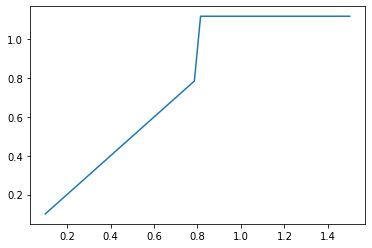

In [7]:
def payoff(x, strike, coupon, u):
    if u > 1:
        x = K.min(x, axis=1)
    b = K.greater_equal(x, strike)
    b = K.cast(b, "float32")
    return (1+coupon)*b + x*(1-b)

x = np.linspace(0.1, 1.5, 50).reshape((-1,1))

plt.plot(x, payoff(x, strike, coupon, 1))
     

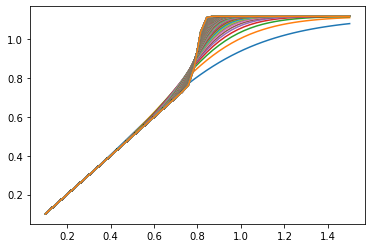

In [8]:
def cash_or_nothing_C(S, K, T, sigma):
    return stats.norm.cdf((np.log(S/K)+(-0.5*sigma**2)*T)/(sigma*np.sqrt(T)), 0, 1)

def asset_or_nothing_P(S, K, T, sigma):
    return S*stats.norm.cdf(-(np.log(S/K)+(0.5*sigma**2)*T)/(sigma*np.sqrt(T)), 0, 1)

for i in range(N):
    plt.plot(x, (1+coupon)*cash_or_nothing_C(x, strike, T/(i+1), sigma) + asset_or_nothing_P(x, strike, T/(i+1), sigma))

In [9]:
u = 1
m = 1
d = 3
n = 32

layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,1),
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]


price = Input(shape=(u,))
hedge = Input(shape=(u,))
hedgeeval = Input(shape=(u,))
premium = Input(shape=(m,))

inputs = [price]+[hedge]+[hedgeeval]+[premium]
outputhelper = []

premium = Dense(m, activation='linear', trainable=True,
                kernel_initializer=initializers.RandomNormal(0,0.1),
                          bias_initializer=initializers.RandomNormal(0,0.1))(premium)

for j in range(N):
    strategy = price
    strategyeval = hedgeeval
    for k in range(d):
        strategy = layers[k+(j)*d](strategy)
        strategyeval = layers[k+(j)*d](strategyeval)
    incr = Input(shape=(u,))
    logprice = Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])

    pricenew = Lambda(lambda x : K.exp(x))(logprice)
    priceincr = Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    hedge = Add()([hedge, hedgenew])
    inputs = inputs + [incr]
    outputhelper = outputhelper + [strategyeval]
    price = pricenew
     

In [10]:
payoff = Lambda(lambda x : payoff(x, strike, coupon, u))(price)
outputs = Subtract()([payoff, hedge])
outputs = Subtract()([outputs, premium])
outputs = [outputs] + outputhelper +[premium]
outputs = Concatenate()(outputs)

In [11]:
model_hedge_strat = Model(inputs=inputs, outputs=outputs)

In [12]:
model_hedge_strat.summary()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
                                                                  '027[1][0]']                    
                                                                                                  
 028 (Dense)                    (None, 32)           64          ['lambda_55[0][0]',              
                                                                  'input_3[0][0]']                
                                                                                                  
 add_354 (Add)                  (None, 1)            0           ['lambda_354[0][0]',             
                                                                  'input_182[0][0]']              
                                                                                                  
 add_51 (Add)                   (None, 1)            0           ['add_49[0][0]',                 
                                                                  'multip